Compare two held-out evaluations sensor-wise.

In [121]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import pandas as pd
import seaborn as sns

In [122]:
eval1 = "../workflow/heilbron2022/evaluations/shift_vs_baseline/EleutherAI/gpt-neo-2.7B/n10000/test_scores.csv"
eval2 = "../workflow/heilbron2022/evaluations/variable_vs_baseline/EleutherAI/gpt-neo-2.7B/n10000/test_scores.csv"
# eval1 = "test_scores1.csv"
# eval2 = "test_scores2.csv"

montage = "biosemi128"

In [123]:
converters = {"model_run": ast.literal_eval}
index_cols = ["model_run", "subject", "run", "sensor"]
eval1_df = pd.read_csv(eval1, converters=converters, index_col=index_cols)
eval2_df = pd.read_csv(eval2, converters=converters, index_col=index_cols)

In [124]:
sensors = sorted(set(eval1_df.index.get_level_values("sensor")))
assert sensors == sorted(set(eval2_df.index.get_level_values("sensor")))

In [131]:
eval1_models = eval1_df.index.get_level_values("model_run").unique()
eval2_models = eval2_df.index.get_level_values("model_run").unique()
base_model = set(eval1_models) & set(eval2_models)
assert len(base_model) == 1
base_model = next(iter(base_model))
eval1_full = next(iter(set(eval1_models) - {base_model}))
eval2_full = next(iter(set(eval2_models) - {base_model}))

In [132]:
eval1_improvement = eval1_df.loc[eval1_full] - eval1_df.loc[base_model]
eval2_improvement = eval2_df.loc[eval2_full] - eval2_df.loc[base_model]

In [133]:
eval1_df

score
model_run               subject run                    sensor          
(_wide, trf)            1       run1/slice:17214:22949 A19    -0.000624
                                                       A7     -0.006729
                                                       B22     0.077013
                                                       B4      0.028612
                                                       C10     0.093330
...                                                                 ...
(_wide, trf-berp-fixed) 9       run9/slice:16884:22511 B4      0.033297
                                                       C10     0.092007
                                                       C22     0.130753
                                                       C32     0.098428
                                                       D19     0.024033

[5776 rows x 1 columns]

-------

In [134]:
info = mne.create_info(sensors, 128, "eeg")
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: A19, A7, B22, B4, C10, C22, C32, D19
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 128.0 Hz
>

In [135]:
eval1_improvement_sensors = eval1_improvement.groupby("sensor").score.mean()
eval1_improvement_sensors.sort_values()

sensor
C10   -0.000671
A7     0.000311
D19    0.000715
C32    0.001664
B22    0.001689
C22    0.001964
A19    0.002107
B4     0.003076
Name: score, dtype: float64

In [136]:
eval2_improvement_sensors = eval2_improvement.groupby("sensor").score.mean()
eval2_improvement_sensors.sort_values()

sensor
C10    0.001378
C32    0.001557
B22    0.001707
C22    0.001845
D19    0.002135
A7     0.002140
B4     0.002252
A19    0.002257
Name: score, dtype: float64

In [137]:
improvements = pd.DataFrame([eval1_improvement_sensors, eval2_improvement_sensors], index=["eval1", "eval2"]).T.sort_index()
improvements

,eval1,eval2
sensor,,
A19,0.002107,0.002257
A7,0.000311,0.002140
B22,0.001689,0.001707
B4,0.003076,0.002252
C10,-0.000671,0.001378
C22,0.001964,0.001845
C32,0.001664,0.001557
D19,0.000715,0.002135


In [138]:
vlim = (improvements.values.min(), improvements.values.max())
from matplotlib.colors import CenteredNorm

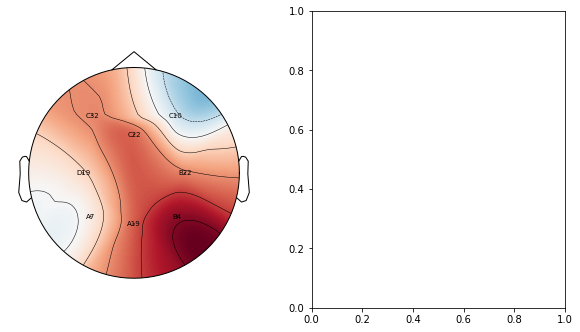

/tmp/ipykernel_140288/3925240791.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1)


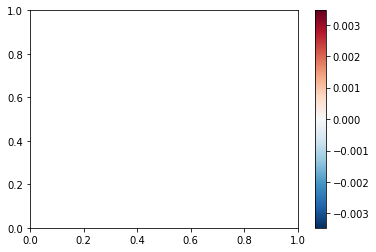

In [139]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
im1, _ = mne.viz.plot_topomap(improvements.eval1,
                              info, cnorm=CenteredNorm(), axes=axs[0], names=improvements.index)
# im2, _ = mne.viz.plot_topomap(improvements.eval2,
#                               info, vlim=vlim, axes=axs[1])
plt.colorbar(im1)

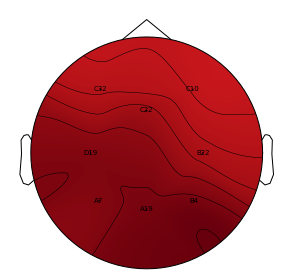

/tmp/ipykernel_140288/70195718.py:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im2)


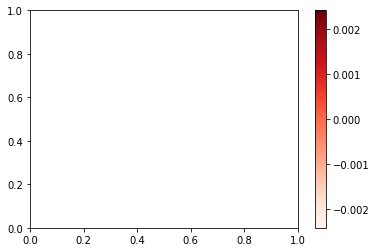

In [140]:
im2, _ = mne.viz.plot_topomap(improvements.eval2,
                              info, cnorm=CenteredNorm(), size=5, names=improvements.index)
plt.colorbar(im2)

-------

In [141]:
(improvements.eval2 - improvements.eval1)

sensor
A19    0.000149
A7     0.001828
B22    0.000018
B4    -0.000824
C10    0.002049
C22   -0.000119
C32   -0.000107
D19    0.001420
dtype: float64

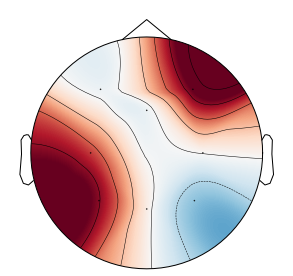

/tmp/ipykernel_140288/2411720068.py:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


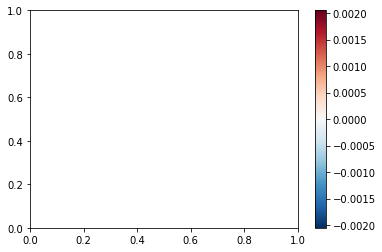

In [142]:
im, _ = mne.viz.plot_topomap((improvements.eval2 - improvements.eval1).sort_index(),
                              info, size=5)
plt.colorbar(im)